In [1]:
import torch
import os, cv2, argparse, json, math, random
import torchvision
import torch.nn as nn
import torchvision.transforms as TR
from torchvision import models

import pandas
import numpy as np
from sklearn import mixture
from sklearn.metrics import accuracy_score
from sklearn import manifold, datasets

import detectron2
from detectron2.engine import DefaultPredictor

from typing import List
from detectron2.data.datasets import register_coco_instances
from detectron2.data import build_detection_test_loader
from detectron2.modeling import build_model

from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.checkpoint import DetectionCheckpointer 
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

from termcolor import colored
from tabulate import tabulate
from datetime import datetime
import sys

import pycocotools.mask
from detectron2.utils.visualizer import Visualizer
from detectron2.evaluation.coco_evaluation import instances_to_coco_json
from torchvision.io import read_image

__all__ = ['StrategyBase', 'RandomStrategy', 'UncertaintyStrategy', 'RoIMatchingStrategy']

/home/aicenter/pyven/pytorch/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch
import PIL, time, datetime, logging, copy, shutil, glob

import detectron2
from collections import UserDict
from detectron2.utils.logger import setup_logger, log_every_n_seconds
import detectron2.utils.comm as comm
import detectron2.data.transforms as T
from detectron2 import model_zoo
from detectron2.structures import BoxMode
from detectron2.config import get_cfg
from detectron2.engine.hooks import HookBase
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.data import DatasetMapper, build_detection_test_loader, build_detection_train_loader
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.evaluation import *
from detectron2.layers.wrappers import Conv2d
from detectron2.layers.batch_norm import FrozenBatchNorm2d
from detectron2.data import detection_utils

First Add your all       
target : img files, json files       
source : img files, json files

In [3]:
#先找好總共的list
#Source(img + json) 
#Target(img + json)
    
with open('/home/aicenter/Ray/data/Active_list/json_target_list.json') as js_ta:
    js_ta = json.load(js_ta)
    js_total_target_list = js_ta['filename']
    
with open('/home/aicenter/Ray/data/Active_list/json_source_list.json')as js_sr:
    js_sr = json.load(js_sr)
    js_total_source_list = js_sr['filename']
    js_total_source_list = js_total_source_list
    
img_total_source_list = [json[:-4] + 'png' for json in js_total_source_list]
img_total_target_list = [json[:-4] + 'png' for json in js_total_target_list]

#Show your budget
print(len(img_total_source_list))
print(len(js_total_source_list))
print(len(js_total_target_list))

80
80
50


Second Third ....Add          
target : img files, json files       
source : img files, json files


In [153]:
#從Active_remain_list找
#Source(img + json) 
#Target(img + json)
    
with open('/home/aicenter/Ray/data/Active_remain_file/json_target_remain_list.json') as js_ta:
    js_ta = json.load(js_ta)
    js_total_target_list = js_ta['filename']
    
with open('/home/aicenter/Ray/data/Active_list/json_source_list.json')as js_sr:
    js_sr = json.load(js_sr)
    js_total_source_list = js_sr['filename']
    js_total_source_list = js_total_source_list
    
img_total_source_list = [json[:-4] + 'png' for json in js_total_source_list]
img_total_target_list = [json[:-4] + 'png' for json in js_total_target_list]

print('------------第二次------------')
print(len(img_total_source_list))
print(len(js_total_source_list))
print(len(js_total_target_list))

------------第二次------------
80
80
20


Define the Box Feature Extractor      

In [4]:
#Use ResNet101 as Feature Extractor 
class Active_ResNet101(nn.Module):
    def __init__(self):
        super(Active_ResNet101, self).__init__()

        # Import the ResNet101 module
        self.model = models.resnet101(pretrained=True)

        # Freeze the parameters
        for param in self.model.parameters():
            param.requires_grad = False

        # Modify the last Fully Connected Network to 256
        self.model.fc = nn.Linear(2048, 256)

    def forward(self, x):
        transform = TR.Resize((250, 250))
        x = transform(x)
        logits = self.model(x)
        return logits

In [5]:
model_res = Active_ResNet101()
torch.save(model_res, 'res.pth')

Because we want the pred_box, we have to transform the target_file and source_file into COCODataset 

In [6]:
from detectron2.structures import BoxMode

DatasetCatalog.clear()
def get_steel_dicts(img_dir,lis):
    classes = ['intersection', 'spacing']
    datasets_dicts = [] 
    
    
    for idx, json_name in enumerate(lis):

            
        with open(os.path.join(img_dir, json_name)) as f: 
            img_anns = json.load(f)

        record = {}
        
        filename = os.path.join(img_dir, img_anns['imagePath'])
        if not os.path.exists(filename):
            continue

        height = img_anns["imageHeight"]
        width = img_anns["imageWidth"]
        
        
        record["file_name"] = filename
        record['image_id'] = idx
        record["height"] = height
        record["width"] = width
        
        annos = img_anns['shapes']
        objs = []
        
        
                
        for anno in annos:
            
            if len(anno["points"]) < 4: 
                continue
            if anno["label"] != "intersection" and anno["label"] != "spacing":
                continue
            
            
            if anno["label"] == "intersection":
                cls = 0
            if anno["label"] == "spacing":
                cls = 1
            
            px = [a[0] for a in anno['points']]
            py = [a[1] for a in anno['points']]
            poly = [(x, y) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]
            
            obj = {
                'bbox':[np.min(px), np.min(py), np.max(px), np.max(py)],
                'bbox_mode':BoxMode.XYXY_ABS,
                'segmentation':[poly],
                'category_id':cls, 
                'iscrowd':0
            }
            objs.append(obj)
        record['annotations'] = objs

        datasets_dicts.append(record)
        
    return datasets_dicts

In [7]:
DatasetCatalog.register("target", lambda : get_steel_dicts('/home/aicenter/Ray/data/Active_source&target', js_total_target_list))
DatasetCatalog.register("source", lambda : get_steel_dicts('/home/aicenter/Ray/data/Active_source&target', js_total_source_list))
MetadataCatalog.get("target").set(thing_classes = ["intersection", "spacing"])
MetadataCatalog.get("source").set(thing_classes = ["intersection", "spacing"])

namespace(name='source', thing_classes=['intersection', 'spacing'])

The Density Select Method below

In [30]:
class Density():
    def __init__(self, k, main_path, middle_ta_path, middle_sr_path, path_target_img_lis, path_source_img_lis, path_target_js_lis, path_source_js_lis, target, source):
        '''
            img_lis, js_lis contain many filename 
            k is the total target budget
        '''
        self.main_path = main_path
        self.middle_ta_path = middle_ta_path
        
        self.middle_sr_path = middle_sr_path
        self.path_target_img_lis = path_target_img_lis
        self.path_target_js_lis = path_target_js_lis
        self.path_source_img_lis = path_source_img_lis
        self.path_source_js_lis = path_source_js_lis
        self.target = target
        self.source = source
        self.k = k

    def density_difference(self, model=None):
        self.k = len(self.path_target_js_lis)
        
        difference_list, KL_Divergence_li, gmm_ta_total, gmm_sr_total, source_img_li, target_img_li = self.GMM_density()
        idx = range(len(difference_list))

        rank = sorted(zip(idx, difference_list), key = lambda x : x[1], reverse=False)
        print('-----------------Rank-----------------')
        print(rank)
        

        top_img_idx_li = []
        for i in range(self.k):
            top_img_idx = rank[i][0]     
            top_img_idx_li.append(top_img_idx)
            
        print(top_img_idx_li)   
        KL_Divergence = np.mean(KL_Divergence_li)
        KL_Divergence = np.abs(KL_Divergence)
        
        #Calculate the KL Divergence 
        print('KL_Divergence')
        print(KL_Divergence)
        
        return top_img_idx_li, gmm_ta_total, gmm_sr_total, KL_Divergence, source_img_li, target_img_li

    def GMM_density(self):
        '''
            target_img_li = [[All crops of 1st pic], [All crops of 2nd pic], [],.................]
            target_img_li = [[[f11....f1n],[f21,...f2n],...], [[[f11....f1n],[f21,...f2n],...], [....],.................]
            target_label_li=[[      0    ],[     1    ],...], [[      1    ],[     0    ],...], [....],.................]
                            [           First pic            ], [             Second pic         ], [....],.................]
        '''  
        source_img_li, source_label_li, probs_sr, gt_label_li_source = self.get_each_features(self.main_path, self.middle_sr_path, self.path_source_img_lis, self.path_source_js_lis, self.source)

        target_img_li, target_label_li, probs_ta, gt_label_li_target = self.get_each_features(self.main_path, self.middle_ta_path, self.path_target_img_lis, self.path_target_js_lis, self.target)
        
#-------------------------------------------------------Transform the dimension, to fit GMM-------------------------------------------------------
        target_img_li_reshape = []
        for i in target_img_li:
            for j in i:
                target_img_li_reshape.append(j)
                
        source_img_li_reshape = []
        for i in source_img_li:
            for j in i:
                source_img_li_reshape.append(j)
        
    
        gmm_ta = mixture.GaussianMixture(n_components=2, random_state=0, verbose=0, n_init=1, max_iter=200).fit(target_img_li_reshape)
        gmm_sr = mixture.GaussianMixture(n_components=2, random_state=0, verbose=0, n_init=1, max_iter=200).fit(source_img_li_reshape)
        
        
        gmm_ta_total = gmm_ta
        gmm_sr_total = gmm_sr
#--------------------------------------------------Calculate GMM Accuracy--------------------------------------------------------------
#         ygmm_ta_pred_class = gmm_ta.predict(target_img_li_reshape)
#         ygmm_sr_pred_class = gmm_sr.predict(target_img_li_reshape)
    
#         print('GMM Prediction')
#         count1, count2 = [], []
#         for x, y in zip(target_label_li, ygmm_ta_pred_class):
#             for i, j in zip(x, y):
#                 if int(i) == int(j):
#                     count1.append(1) 
#         acc_ta = sum(count1)/len(target_img_li_reshape)*100
#         print(acc_ta)
        
#         for x, y in zip(source_label_li, ygmm_sr_pred_class):
#             for i, j in zip(x, y):
#                 if int(i) == int(j):
#                     count2.append(1) 
#         acc_sr = sum(count2)/len(target_img_li_reshape)*100
#         print(acc_sr)
        

        
#         df_ta = pandas.DataFrame(dict(Feature_1=X1_tsne[:,0], Feature_2=X1_tsne[:,1], label=ta_y))
#         df_ta.plot(x="Feature_1", y="Feature_2", kind='scatter', c='label', colormap='virdis')
        

#         df_sr = pandas.DataFrame(dict(Feature_1=X2_tsne[:,0], Feature_2=X2_tsne[:,1], label=sr_y))
#         df_sr.plot(x="Feature_1", y="Feature_2", kind='scatter', c='label', colormap='virdis')

        
#----------------------------------------------------------------------------------------------------------------------------------
 
        
        pi_max = []
        pi_li = []
        KL_Divergence_li = []
        for target_features, source_features, target_prob, source_prob, target_label, source_label in zip(target_img_li, source_img_li, probs_ta, probs_sr, target_label_li, source_label_li):
            X_target = target_features
            X_source = source_features
            source_prob = source_prob
            target_prob = target_prob
            y_target = target_label
            y_source = source_label
            
#--------------------------------------------------According label to ration---------------------------------------------------------------
            
            idx_ta_0 = [i[0] for i in enumerate(y_target) if i[1] == 0]   #target, the position where predict 0 
            idx_ta_1 = [i[0] for i in enumerate(y_target) if i[1] == 1]   #target, the position where predict 1
            idx_sr_0 = [i[0] for i in enumerate(y_source) if i[1] == 0]   #source, the position where predict 0
            idx_sr_1 = [i[0] for i in enumerate(y_source) if i[1] == 1]   #source, the position where predict 1
            
            x_target_0 = [X_target[i] for i in idx_ta_0]
            x_target_1 = [X_target[i] for i in idx_ta_1]
            
            x_source_0 = [X_source[i] for i in idx_sr_0]
            x_source_1 = [X_source[i] for i in idx_sr_1]
            

#-------------------------------------------------Predict each crops' Density-----------------------------------------------------------
#-----------------------------------Predict each features of crops' density，['intersection, spacing]--------------------------------
            count_0 = 0
            for _ in range(1):
                if len(x_target_0) == 0:
                    count_0 += 1
                    continue         
                else:    
                    like_target_0 = gmm_ta.score_samples(x_target_0)
                    like_source_0 = gmm_sr.score_samples(x_target_0)
            
            count_1 = 0
            for _ in range(1):
                if len(x_target_1) == 0:
                    count_1 += 1
                    continue          
                else:    
                    like_target_1 = gmm_ta.score_samples(x_target_1)
                    like_source_1 = gmm_sr.score_samples(x_target_1)
            print('----------------------ta_likelihood-----------------------')
            print(like_target_0)
            print(like_target_1)

            
#-------------------------------------------------Calculate Domain shift-----------------------------------------------------------
#If the picture is not predicted the certain class, we have to skip
#count_0 == 1 is that didn't predict to some class 0, so we just do pi_1
#count_1 == 1 is that didn't predict to some class 1, so we just do pi_0

            if count_0 == 1:
                pi_1 = sum(like_source_1 - like_target_1)
                pi = pi_1
            if count_1 == 1:
                pi_0 = sum(like_source_0 - like_target_0)
                pi = pi_0
            if count_0 != 1 and count_1 != 1:
                pi_0 = sum(like_source_0 - like_target_0)
                pi_1 = sum(like_source_1 - like_target_1)
                
            pi = pi_0 + pi_1
            kl_divergence = pi/(len(x_target_0) + len(x_target_1))
            print('----------------- Source-Target Domain of this picture------------------')
            print(pi)
            
            pi_li.append(pi)
            KL_Divergence_li.append(kl_divergence)
            
        return pi_li, KL_Divergence_li, gmm_ta_total, gmm_sr_total, source_img_li, target_img_li

    def get_each_features(self, main_l, middle_path, pic_l, js_l, cocodata):

        cfg = get_cfg()
        cfg.thing_classes = ['intersection', 'spacing']
        cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
        cfg.DATASETS.TEST = (cocodata,)
        cfg.MODEL.WEIGHTS = '/home/aicenter/Ray/data/Model_weight/Active_secondtry_dynamic2/model_final.pth'  #Put my pretrained model
        cfg.DATALOADER.NUM_WORKERS = 2
        cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2
        cfg.SOLVER.IMS_PER_BATCH = 1
        cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
        cfg.MODEL.DEVICE = 'cuda'

        model = build_model(cfg)

        DetectionCheckpointer(model).load(cfg.MODEL.WEIGHTS)
        
        loader = build_detection_test_loader(cfg, cocodata)
              
        img_feature_li = []
        pred_label_li = []
        prob_li = []
        for i, j in zip(range(len(pic_l)), loader):
            print('-----------------Round------------------')
            print('idx', i)
            
            #Read the '.png' and '.json'
            images = read_image(os.path.join(main_l, middle_path, pic_l[i]))
            with open(os.path.join(main_l, middle_path, js_l[i])) as js:
                js_file = json.load(js)
            
            gt = js_file["shapes"]
            gt_label_li = []
            for i in gt:
                gt_label = i['label']
                gt_label_li.append(gt_label)
            
            
            crops, pred_label, probs = self.get_crops(model, j) #crops = image很多的切片,是個list
            
            
            pred_label_li.append(pred_label)
            prob_li.append(probs)
            
#             for b_feat in box_features:
#                 img_feature_li.append(torch.reshape(b_feat.type(torch.FloatTensor).to(torch.device('cuda'), (-1,)))

            #Import our ResNet101
            model_extractor = torch.load('res.pth')
            model_extractor.eval()
            with torch.no_grad():
                features = [] #Each features of crops
                for crop in crops:
                    each_crop = torch.unsqueeze(crop, 0).type(torch.FloatTensor)
                    each_features = model_extractor(each_crop)
                    features.append(np.array(torch.squeeze(each_features, 0)))

            torch.save(model_extractor, 'res.pth')
            img_feature_li.append(features)

        return img_feature_li, pred_label_li, prob_li, gt_label_li

    
    def forward_boxes(self, model, img, return_features=False):
        
        model.eval()
        with torch.no_grad():
            images = model.preprocess_image(img)
            features = model.backbone(images.tensor)
#             img = torch.unsqueeze(data, 0).type(torch.FloatTensor).to(torch.device('cuda'))
#             images = img
#             print(img.shape)
#             features = model.backbone(images)

            if model.proposal_generator is not None:
                proposals, _ = model.proposal_generator(images, features, None)
            else:
                assert "proposals" in data[0]
                proposals = [x["proposals"].to(model.device) for x in data]
            box_in_features = [features[f] for f in model.roi_heads.box_in_features]
            box_features = model.roi_heads.box_pooler(box_in_features, [x.proposal_boxes for x in proposals])
            box_features = model.roi_heads.box_head(box_features)
            predictions = model.roi_heads.box_predictor(box_features)
            

            scores = model.roi_heads.box_predictor.predict_probs(predictions, proposals)
            pred_boxes, indices = model.roi_heads.box_predictor.inference(predictions, proposals)
            pred_boxes[0].scores = scores[0][indices][:, :-1]
            
            
        if return_features == True:
            return 0
        else:
            return pred_boxes[0].pred_boxes, pred_boxes[0].pred_classes, scores, images
        
    
    def get_crops(self, model, img):
        
        
        pred_boxes, classes, probs, images = self.forward_boxes(model, img)
        
        img = images[0]
        pred_label = []
        for cls in classes:
            pred_label.append(cls)
            
        crops = []
        for box in pred_boxes:
            #The smallest (x, y)
            box_size = len(box)
            x_min = int(box[0])
            y_min = int(box[1])
            
            x_max = int(box[2])
            y_max = int(box[3])
            w = abs(x_max-x_min)
            h = abs(y_max-y_min)
    
            if w != 0 and h != 0:
                crop_each = img[:, y_min:y_max, x_min:x_max]
            else:
                continue
            
            crops.append(crop_each)
            
        return crops, pred_label, probs

    


In [31]:
#Density Select

import matplotlib.pyplot as plt

main_path = '/home/aicenter/Ray/data/'

ta_im_path = 'Active_target'
sr_im_path = 'Active_source'

#k = default, ta_im_path, sr_im_path, ta_im, sr_im, ta_js, sr_js

density_sample_active_train = Density(1, main_path, ta_im_path, sr_im_path, img_total_target_list, img_total_source_list, js_total_target_list, js_total_source_list, 'target', 'source')
idx_li, gmm_ta_total, gmm_sr_total, KL_Divergence, source_img_li, target_img_li = density_sample_active_train.density_difference()

-----------------進度------------------
idx 0
-----------------進度------------------
idx 1
-----------------進度------------------
idx 2
-----------------進度------------------
idx 3
-----------------進度------------------
idx 4
-----------------進度------------------
idx 5
-----------------進度------------------
idx 6
-----------------進度------------------
idx 7
-----------------進度------------------
idx 8
-----------------進度------------------
idx 9
-----------------進度------------------
idx 10
-----------------進度------------------
idx 11
-----------------進度------------------
idx 12
-----------------進度------------------
idx 13
-----------------進度------------------
idx 14
-----------------進度------------------
idx 15
-----------------進度------------------
idx 16
-----------------進度------------------
idx 17
-----------------進度------------------
idx 18
-----------------進度------------------
idx 19
-----------------進度------------------
idx 20
-----------------進度------------------
idx 21
-----------------進度-

----------------------ta_likelihood-----------------------
[   7.57509147    9.2885577   -12.96614494   47.58671761   57.53064148
   10.81099853   -1.15663386   27.67399015   24.50272855   58.96016997
   57.6592164    27.71824076   -4.73612958   12.00856362 -189.26005952
   17.10788198   32.52090667   31.34834965  -22.55587668   31.59212004
  -42.71457844   36.34869845    5.50240497   81.53554677   26.07435513
    1.04843141    8.03870217   -5.23557235]
[ -94.13668154 -112.79104837  -83.8734371  -139.61253249  -91.21265341
  -63.165626    -48.70686191  -42.95452395  -12.7390903  -130.66290944
 -119.91849084  -71.44865158  -82.14692611 -215.54107352 -116.40422237
 -177.82775015 -110.54914578  -72.19144376  -42.71134293  -60.87998366
 -145.58576717 -148.42550113 -270.5236727   -65.67846696  -42.36894419
   36.41858518  -80.29216927  -19.84084772 -155.42380055  -65.62026011
 -136.23846227 -144.44926037 -118.75086645 -167.22123733 -139.73472507
 -144.26007717  -55.56044379   29.72401096 -1

----------------------ta_likelihood-----------------------
[ -17.51809648   12.02168088   13.94241509  -44.89829139  -56.72952773
   -8.33070274   19.00070487  -41.46288914  -10.86783636  -44.00736562
    1.11224859  -29.46245513    1.38498953  -12.25845585  -34.61852638
   -0.94989076   -3.18681244 -116.80033818  -14.02733116  -38.87283483
  -26.01780423]
[ -29.74292059  -90.261502   -132.43322866  -78.0253188   -80.4025141
  -75.81883274  -18.75047393    2.39294063  -65.12048891  -40.98808758
  -52.0436343    -9.3157328   -84.30862268  -60.88102759 -120.66509763
  -41.05415868  -56.11842809  -72.58238217  -70.67262877  -86.95868488
  -59.71768201  -48.51764289  -44.83849364  -77.43910945  -47.58967844
  -43.29712272  -52.72954186  -58.16590429  -24.52085659  -68.58713294
  -78.51243228  -44.22786959  -47.02458922  -33.67519147  -62.8418525
  -14.5733908   -88.88142797  -51.18789622  -86.16991122 -105.39028906
  -16.62573339  -56.92018103  -95.02984587  -91.69874267  -81.26940789
  -2

len_ta
[1 0 1 ... 0 0 0]
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3823 samples in 0.001s...


/home/aicenter/pyven/pytorch/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computed neighbors for 3823 samples in 0.212s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3823
[t-SNE] Computed conditional probabilities for sample 2000 / 3823
[t-SNE] Computed conditional probabilities for sample 3000 / 3823
[t-SNE] Computed conditional probabilities for sample 3823 / 3823
[t-SNE] Mean sigma: 11.801483
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.725899
[t-SNE] KL divergence after 1000 iterations: 0.830938
len_sr
[1 1 1 ... 1 0 0]
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5895 samples in 0.001s...


/home/aicenter/pyven/pytorch/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computed neighbors for 5895 samples in 0.521s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5895
[t-SNE] Computed conditional probabilities for sample 2000 / 5895
[t-SNE] Computed conditional probabilities for sample 3000 / 5895
[t-SNE] Computed conditional probabilities for sample 4000 / 5895
[t-SNE] Computed conditional probabilities for sample 5000 / 5895
[t-SNE] Computed conditional probabilities for sample 5895 / 5895
[t-SNE] Mean sigma: 12.832488
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.598747
[t-SNE] KL divergence after 1000 iterations: 1.103018


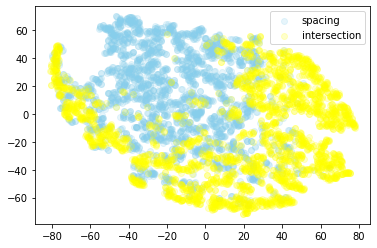

In [33]:
#-------------------------------------------------Plot Density Domain--------------------------------------------------------------

target_img_li_reshape = []
for i in target_img_li:
    for j in i:
        target_img_li_reshape.append(j)

source_img_li_reshape = []
for i in source_img_li:
    for j in i:
        source_img_li_reshape.append(j)

ta_y = gmm_ta_total.predict(target_img_li_reshape)
print('len_ta')
print(ta_y)
X1 = target_img_li_reshape
X1_tsne = manifold.TSNE(n_components=2, init='random', random_state=5, verbose=1).fit_transform(X1)
X1_tsne = np.array(X1_tsne)
ta_y_0 = [(i, j) for i, j in enumerate(ta_y) if j == 0]
ta_y_1 = [(i, j) for i, j in enumerate(ta_y) if j == 1]
X1_tsne_0 = [X1_tsne[i[0]] for i in ta_y_0]
X1_tsne_1 = [X1_tsne[i[0]] for i in ta_y_1]

x_X1_tsne_0 = [i[0] for i in X1_tsne_0]
y_X1_tsne_0 = [i[1] for i in X1_tsne_0]

x_X1_tsne_1 = [i[0] for i in X1_tsne_1]
y_X1_tsne_1 = [i[1] for i in X1_tsne_1]


sr_y = gmm_sr_total.predict(source_img_li_reshape)
print('len_sr')
print(sr_y)  
X2 = source_img_li_reshape
X2_tsne = manifold.TSNE(n_components=2, init='random', random_state=5, verbose=1).fit_transform(X2)
X2_tsne = np.array(X2_tsne)
sr_y_0 = [(i, j) for i, j in enumerate(sr_y) if j == 0]
sr_y_1 = [(i, j) for i, j in enumerate(sr_y) if j == 1]
X2_tsne_0 = [X2_tsne[i[0]] for i in sr_y_0]
X2_tsne_1 = [X2_tsne[i[0]] for i in sr_y_1]

x_X2_tsne_0 = [i[0] for i in X2_tsne_0]
y_X2_tsne_0 = [i[1] for i in X2_tsne_0]

x_X2_tsne_1 = [i[0] for i in X2_tsne_1]
y_X2_tsne_1 = [i[1] for i in X2_tsne_1]


# plt.scatter(x_X1_tsne_0, y_X1_tsne_0, data = ta_y_0, alpha = 0.2, marker='o', c='skyblue', label="spacing")
# plt.scatter(x_X1_tsne_1, y_X1_tsne_1, data = ta_y_1, alpha = 0.2, marker='o', c='yellow', label="intersection")
# plt.legend()


plt.scatter(x_X2_tsne_0, y_X2_tsne_0, data = sr_y_0, alpha = 0.2, marker='o', c='skyblue', label="spacing")
plt.scatter(x_X2_tsne_1, y_X2_tsne_1, data = sr_y_1, alpha = 0.2, marker='o', c='yellow', label="intersection")
plt.legend()

plt.show()

/home/aicenter/pyven/pytorch/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3823 samples in 0.001s...
[t-SNE] Computed neighbors for 3823 samples in 0.207s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3823
[t-SNE] Computed conditional probabilities for sample 2000 / 3823
[t-SNE] Computed conditional probabilities for sample 3000 / 3823
[t-SNE] Computed conditional probabilities for sample 3823 / 3823
[t-SNE] Mean sigma: 11.801483
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.725899
[t-SNE] KL divergence after 1000 iterations: 0.830938


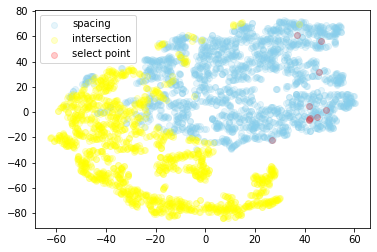

In [35]:
#---------------------------------------------------------------------Plot the Density--------------------------------------------
import matplotlib.cm as cm

select = target_img_li[idx_li[0]]

target_img_li_reshape = []
for i in target_img_li:
    for j in i:
        target_img_li_reshape.append(j)

source_img_li_reshape = []
for i in source_img_li:
    for j in i:
        source_img_li_reshape.append(j)

#print(target_img_li_reshape[0])
#Get the selected position
index_ta_li = []
for i, j in enumerate(target_img_li_reshape):
    for x in select:
        if (x == j).all():
            index_ta_li.append(i)
    
# index_sr_li = []
# for i in select:
#     index = source_img_li_reshape.index(i)
#     index_sr_li.append(index)
        
ta_y = gmm_ta_total.predict(target_img_li_reshape)
score_ta = gmm_ta_total.score_samples(target_img_li_reshape)
score_sr = gmm_sr_total.score_samples(target_img_li_reshape)
score_ta = [score_ta[i] for i in index_ta_li]
score_sr = [score_sr[i] for i in index_ta_li]

X1 = target_img_li_reshape
X1_tsne = manifold.TSNE(n_components=2, init='random', random_state=5, verbose=1).fit_transform(X1)
X1_tsne = np.array(X1_tsne)

ta_y_0 = [(i, j) for i, j in enumerate(ta_y) if j == 0]
ta_y_1 = [(i, j) for i, j in enumerate(ta_y) if j == 1]

X1_tsne_0 = [X1_tsne[i[0]] for i in ta_y_0]
X1_tsne_1 = [X1_tsne[i[0]] for i in ta_y_1]

x_X1_tsne_0 = [i[0] for i in X1_tsne_0]
y_X1_tsne_0 = [i[1] for i in X1_tsne_0]

x_X1_tsne_1 = [i[0] for i in X1_tsne_1]
y_X1_tsne_1 = [i[1] for i in X1_tsne_1]

feature_ta = [X1_tsne[i] for i in index_ta_li]
x_feature_ta = [i[0] for i in feature_ta]
y_feature_ta = [i[1] for i in feature_ta]


label_ta = [ta_y[i] for i in index_ta_li]
score_diff = [i - j for i, j in zip(score_sr, score_ta)]
score_diff_rank = np.argsort(score_diff)
x_feature_top10 = [x_feature_ta[i] for i in score_diff_rank[:10]]
y_feature_top10 = [y_feature_ta[i] for i in score_diff_rank[:10]]
label_ta_top10 = [label_ta[i] for i in score_diff_rank[:10]]


plt.scatter(x_X1_tsne_0, y_X1_tsne_0, data=ta_y_0, alpha = 0.2, marker='o', c='skyblue', label="spacing")                 #總共的
plt.scatter(x_X1_tsne_1, y_X1_tsne_1, data=ta_y_1, alpha = 0.2, marker='o', c='yellow', label="intersection")
plt.scatter(x_feature_top10, y_feature_top10, data=label_ta_top10, alpha = 0.2, c="red", label="select point")              #有選到的
plt.legend()
plt.show()

# plt.scatter(x_X1_tsne_0, y_X1_tsne_0, data=ta_y_0, alpha = 0.2, marker='o', c='skyblue', label="spacing")                 #總共的
# plt.scatter(x_X1_tsne_1, y_X1_tsne_1, data=ta_y_1, alpha = 0.2, marker='o', c='yellow', label="intersection")
# plt.scatter(x_feature_ta, y_feature_ta, data=label_ta, alpha = 0.2, c="red", label="select point")                       #有選到的
# plt.legend()
# plt.show()

# sr_y = gmm_sr_total.predict(source_img_li_reshape)
# print('len_sr')
# print(len(sr_y))
# X2 = source_img_li_reshape
# X2_tsne = manifold.TSNE(n_components=2, init='random', random_state=5, verbose=1).fit_transform(X2)
# X2_tsne = np.array(X2_tsne)
# x_X2_tsne = [i[0] for i in X1_tsne]
# y_X2_tsne = [i[1] for i in X1_tsne]
# # feature_sr = [X2_tsne[i] for i in index_sr_li]
# # label_sr = [sr_y[i] for i in index_sr_li]

# plt.scatter(x_X2_tsne, y_X2_tsne, data=sr_y, alpha = 0.2)




# df_ta = pandas.DataFrame(dict(Feature_1=X1_tsne[:,0], Feature_2=X1_tsne[:,1], label=ta_y), colormap='viridis')
# #df_ta_highlight = pandas.DataFrame(dict(Feature_1=feature_ta[:,0], Feature_2=feature_ta[:,1], label=label_ta))
# df_ta.plot(x="Feature_1", y="Feature_2", kind='scatter')
# #df_ta_highlight.plot(x="Feature_1", y="Feature_2", kind='scatter', colormap='YlGnBu_r', label=label_ta, ax = ax_ta)


# df_sr = pandas.DataFrame(dict(Feature_1=X2_tsne[:,0], Feature_2=X2_tsne[:,1], label=sr_y))
# #df_sr_highlight = pandas.DataFrame(dict(Feature_1=feature_sr[:,0], Feature_2=feature_sr[:,1], label=label_sr))
# df_sr.plot(x="Feature_1", y="Feature_2", kind='scatter', c='label', colormap='viridis')
# #df_sr_highlight.plot(x="Feature_1", y="Feature_2", kind='scatter', colormap='Green', label=label_sr, ax_sr = ax_sr)





In [98]:
#Save the GMM Model
gmm_ta_total = gmm_ta_total
gmm_sr_total = gmm_sr_total

Start to Dynamic Scheduling

In [102]:
class DynamicScheduling():
    def __init__(self, k):
        #The parameters can adjust by yourself

        self.apha = 0.5
        self.beta = 1
        
        self.k = k  #The which round of selection

    def get_ration_file(self, budget):
        self.budget = budget
        db, ub = self.ration(self.budget)
        
        print('uncertain_budget :', ub)
        print('density_budget :', db)
         
        return db, ub   

    def ration(self, budget):
        density_budget = self.apha*2**(-self.beta*(self.k-1))*budget
        uncertain_budget = budget - density_budget
        
        return round(density_budget), round(uncertain_budget)

In [103]:
#Print the selected Density_list_json, Density_list_png
#Print the according Source_list_json, Source_list_png
#Print the according Density_list_json

dynamic = DynamicScheduling(1)
density_budget, uncertain_budget = dynamic.get_ration_file(10)

#According target
density_ta_sort = [js_total_target_list[i] for i in idx_li]                            #Sort
density_li = density_ta_sort[0:density_budget]                                         #Bring the selected budget according the budget computed
uncertain_li = density_ta_sort[density_budget:]                                        #Put the remaining budget to Uncertainty Select 
density_selected_ta_js = density_li                       
density_selected_ta_img = [json[:-5] + '.png' for json in density_selected_ta_js]      #The selected json file transform to '.ong'

density_remain_ta_js = uncertain_li
density_remain_ta_img = [json[:-5] + '.png' for json in density_remain_ta_js]

#對應挑出來的source
# density_sr_sort = [js_total_source_list[i] for i in idx_li]                          #先做排序
# density_selected_sr_js = density_sr_sort[0:density_budget]                           #拿出前幾個
# density_selected_sr_img = [json[:-5] + '.png' for json in density_selected_sr_js]    #轉換成img譡

# density_remain_sr_js = density_sr_sort[density_budget:]                              #拿出後幾個json
# density_remain_sr_img = [json[:-5] + '.png' for json in density_remain_sr_js]        #拿出後幾個img


total_list = density_li + uncertain_li

print('------------total_list--------------')
print(total_list)
print('------------density_selected_ta_js-----------')
print(density_selected_ta_js)
print('------------density_selected_ta_img----------')
print(density_selected_ta_img)
print('------------density_selected_sr_js-----------')
# print(density_selected_sr_js)
# print('------------density_selected_sr_img----------')
# print(density_selected_sr_img)
# print('------------uncertainty_li，要去做下一階段----------')
print(uncertain_li)

uncertain_budget : 10
density_budget : 0
------------total_list--------------
['20191024_094332_35692.json', '20191024_094332_35706.json', '20191024_103059_115650.json', '20191024_100019_63464.json', '20191024_100019_63625.json', '20191024_100109_64573.json', '20191024_095044_47364.json', '20191024_100109_64803.json', '20191024_095044_47476.json', '20191024_102745_110032.json', '20191024_102556_106690.json', '20191024_102556_107024.json', '20191024_102556_106976.json', '20191024_102556_107000.json', '20191024_102852_112142.json', '20191024_102852_112304.json', '20191024_102556_107044.json', '20191024_102556_106731.json', '20191024_102745_110468.json', '20191024_102556_106966.json', '20191024_102057_98604.json', '20191024_102556_106811.json', '20191024_102745_110127.json', '20191024_102556_106789.json', '20191024_095846_60844.json', '20191220_104204_2969.json', '20191024_095846_60679.json', '20191024_095846_60868.json', '20191220_104204_3839.json', '20191220_104204_5150.json', '20191024

Register the Uncertainty Budget

In [105]:
DatasetCatalog.register("my_train", lambda : get_steel_dicts('/home/aicenter/Ray/data/Active_target', uncertain_li))
#DatasetCatalog.register("active_test", lambda : get_steel_dicts('/home/aicenter/summer_train/summer_intern/COCO/dataset', test_set))
MetadataCatalog.get("my_train").set(thing_classes = ["intersection", "spacing"])
#MetadataCatalog.get("active_test").set(thing_classes = ["intersection", "spacing"])

namespace(name='my_train', thing_classes=['intersection', 'spacing'])

Uncertainty Selection

In [106]:
def _forward_boxes(model, data, return_features=False):
    #Data is a pictures which contain lots of pred_boxes
    
    model.eval()
    with torch.no_grad():
        images = model.preprocess_image(data)
        features = model.backbone(images.tensor)
#        img = torch.unsqueeze(im, 0).type(torch.FloatTensor).to(torch.device('cuda'))
#        features = model.backbone(img)

        if model.proposal_generator is not None:
            proposals, _ = model.proposal_generator(images, features, None)
        else:
            assert "proposals" in data[0]
            proposals = [x["proposals"].to(model.device) for x in data]
        box_in_features = [features[f] for f in model.roi_heads.box_in_features]
        box_features = model.roi_heads.box_pooler(box_in_features, [x.proposal_boxes for x in proposals])
        box_features = model.roi_heads.box_head(box_features)
        predictions = model.roi_heads.box_predictor(box_features)
        scores = model.roi_heads.box_predictor.predict_probs(predictions, proposals)
        pred_boxes, indices = model.roi_heads.box_predictor.inference(predictions, proposals)
        pred_boxes[0].scores = scores[0][indices][:, :-1]

    if return_features:
        return pred_boxes[0], list(features.values())
    else:
        return pred_boxes[0]

class StrategyBase:
    """
    Base class for query strategy.
    """
    def __init__(self):
        pass
    
    @classmethod
    def sample(self, model, pool_name, k):
        """
        Sample k instances from data.
        Args:
            model (torch.nn.Module): a model for querying samples.
            pool_name (str): name of pool set.
            k (int): an interger number for sampling.
        Returns:
            image_id of sampled instances.
        """
        raise NotImplementedError
    
    def __str__(self):
        return f"{type(self).__name__}({', '.join(['{}={}'.format(attr, value) for attr, value in self.__dict__.items()])})"



class UncertaintyStrategy(StrategyBase):
    """
    Uncertainty sampling query strategy. Selects instances with the least confidence for labeling.
    Args:
        measurement (str): measurement method for uncertainty estimation which must be 
            in list of ['uncertainty', 'margin', 'entropy']
        aggregation (str): a aggregation method to aggregate measurements of detections which must be
            in list of ['sum', 'mean', 'max']
    """
    def __init__(self, measurement='uncertainty', aggregation='mean'):
        assert measurement in ['uncertainty', 'margin', 'entropy'], "measurement method must be in list of ['uncertainty', 'margin', 'entropy']"
        assert aggregation in ['sum', 'mean', 'max'], "aggregation function must be in list of ['sum', 'mean', 'max']"
        self.measurement = measurement
        self.aggregation = aggregation
    
    def get_uncertainty(self, scores):
        if self.measurement == "uncertainty":
            metrics = 1 - scores.max(-1)[0]
        elif self.measurement == "margin":
            metrics = torch.diff(torch.topk(scores, 2, dim=-1)[0], dim=-1).view(-1)
        elif self.measurement == "entropy":
            metrics = - torch.sum(scores * torch.log(scores), -1)
        
        if self.aggregation == "sum":
            metrics = torch.sum(metrics)
        elif self.aggregation == "mean":
            metrics = torch.mean(metrics)
        elif self.aggregation == "max":
            metrics = torch.max(metrics)
        return metrics
    
    def sample(self, cfg, pool_name, k, model=None, verbose=True, skip=1):
        if model is None:
            model = build_model(cfg)
        loader = build_detection_test_loader(cfg, pool_name)
        metrics_dict = {}
        for iter, data in enumerate(loader):
            if iter % skip == 0:
                pred_boxes = _forward_boxes(model, data)
                metrics = self.get_uncertainty(pred_boxes.scores)
                metrics_dict[data[0]["image_id"]] = float(metrics)
        
        rank = sorted(metrics_dict.items(), key=lambda x: x[1], reverse=True)    # Active Learning
        # rank = sorted(metrics_dict.items(), key=lambda x: x[1], reverse=False)    # Pseudo Labeling
        
        if verbose:
            headers = ['Selected files', 'Scores']
            contents = rank[:k]
            ctable(headers, contents, title="UncertaintyStrategy.Selected", color='yellow')
            print(rank)
        return [r[0] for r in rank[:k]]


#所以我的anno就是一個檔案裡面含一堆照片，每張都包含了一堆已label instances
#我將我所有predict好的照片僧過一輪，看看哪些事也包含在uncertainty-sample的
def get_image_id(selected_file, uncertainty_sample):
    print('-------------------Uncertainty_Selected-----------------')
    uncertainty_selected_li = []
    for selected in uncertainty_sample:
        uncertainty_selected_li.append(selected_file[selected])
    
    print(uncertainty_selected_li)
    
    return uncertainty_selected_li, uncertainty_sample


from detectron2.structures import BoxMode

def main():
    #register_coco_instances('active_train', {}, '/home/aicenter/Ray/data/annotations_train.json', '/home/aicenter/summer_train/summer_intern/COCO/dataset')
    
    UncertaintyModule = UncertaintyStrategy(measurement='entropy')
    # RoIModule = RoIMatchingStrategy()

    cfg = get_cfg()
    cfg.thing_classes = ['intersection', 'spacing']
    cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
    cfg.DATASETS.TRAIN = ("my_train",)
    cfg.MODEL.WEIGHTS = '/home/aicenter/Ray/data/Model_weight/Active1/model_final.pth'  #把我前一次train好的load進來
    cfg.DATALOADER.NUM_WORKERS = 2
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2
    cfg.SOLVER.IMS_PER_BATCH = 4
    # cfg.MODEL.WEIGHTS = "./pretrained_model/model_final.pth"
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
    #cfg.OUTPUT_DIR = '/home/aicenter/Ray/model_final.pth'
    cfg.MODEL.DEVICE = 'cuda'

    model = build_model(cfg)

    DetectionCheckpointer(model).load(cfg.MODEL.WEIGHTS)

    print("############ active_test ############")
    

    #------------------------------------First_loop--------------------------------------------------------

    uncertainty_sample_active_train = UncertaintyModule.sample(cfg, "my_train", k=uncertain_budget, model=model, skip=1)

    selected_file = uncertain_li
    uncertainty_selected_li, uncertainty_id = get_image_id(selected_file, uncertainty_sample_active_train)

    return uncertainty_selected_li, uncertainty_id
    
if __name__ == '__main__':
    uncertainty_selected_li, uncertainty_id = main()


############ active_test ############
[2022/08/13 21:06:48 UncertaintyStrategy.Selected]:
+----------------+---------------------+
| Selected files |       Scores        |
+----------------+---------------------+
|       30       | 0.18867729604244232 |
|       24       | 0.1880212128162384  |
|       26       | 0.1870139092206955  |
|       27       | 0.18666131794452667 |
|       31       | 0.1800030767917633  |
|       22       | 0.17569199204444885 |
|       47       | 0.16508302092552185 |
|       9        | 0.16110292077064514 |
|       12       | 0.15784713625907898 |
|       13       | 0.15767629444599152 |
+----------------+---------------------+
[(30, 0.18867729604244232), (24, 0.1880212128162384), (26, 0.1870139092206955), (27, 0.18666131794452667), (31, 0.1800030767917633), (22, 0.17569199204444885), (47, 0.16508302092552185), (9, 0.16110292077064514), (12, 0.15784713625907898), (13, 0.15767629444599152), (19, 0.15343673527240753), (35, 0.1481260359287262), (18, 0.146128728

In [107]:
#將選到的json檔從total 除名再dump回去

for file in total_list:
    
    if file in uncertainty_selected_li:
        total_list.remove(file)
        
    if file in density_selected_ta_js:
        total_list.remove(file)
        
    if file in density_selected_sr_js:
        total_list.remove(file)
        
print('---------------------------Total_List Remain---------------------------')
print(len(total_list))

NameError: name 'density_selected_sr_js' is not defined

In [108]:
# Active_selected_list

# Write uncertainty_selected_list
uncertain_dict = {'filename': []}
with open('/home/aicenter/Ray/data/Active_selected_file/json_uncertain_selected_list.json', 'w') as f:
    uncertain_dict['filename'] = uncertainty_selected_li
    json.dump(uncertain_dict, f)

# Write density_selected_list的
ta = {'filename': []}
ta['filename'] = density_selected_ta_js
with open('/home/aicenter/Ray/data/Active_selected_file/json_target_selected_list.json', 'w') as f:
    json.dump(ta, f)

Remove the selected file 

In [109]:
remain_ta_js = density_remain_ta_js
remain_ta_img = density_remain_ta_img

temp1 = []
temp2 = []
for i in uncertainty_id:
    temp1.append(remain_ta_js[i])
    temp2.append(remain_ta_img[i])

for i in temp1:
    if i in remain_ta_js:
        remain_ta_js.remove(i)
    else:
        continue
        
for i in temp2:
    if i in remain_ta_img:
        remain_ta_img.remove(i)
    else:
        continue
print('--------------------------img_total_target_list_Remain-----------------')
print(len(remain_ta_img))
print('--------------------------js_total_target_list_Remain------------------')
print(remain_ta_js)

    

--------------------------img_total_target_list_Remain-----------------
40
--------------------------js_total_target_list_Remain------------------
['20191024_094332_35692.json', '20191024_094332_35706.json', '20191024_103059_115650.json', '20191024_100019_63464.json', '20191024_100019_63625.json', '20191024_100109_64573.json', '20191024_095044_47364.json', '20191024_100109_64803.json', '20191024_095044_47476.json', '20191024_102556_106690.json', '20191024_102556_107024.json', '20191024_102852_112142.json', '20191024_102852_112304.json', '20191024_102556_107044.json', '20191024_102556_106731.json', '20191024_102745_110468.json', '20191024_102556_106966.json', '20191024_102057_98604.json', '20191024_102556_106811.json', '20191024_102556_106789.json', '20191220_104204_2969.json', '20191220_104204_3839.json', '20191220_104204_5150.json', '20191220_104204_3214.json', '20191220_104047_968.json', '20191220_104047_893.json', '20191024_102556_106924.json', '20191220_104204_5442.json', '20191024

Write the remaining files to Active_remian_list

In [110]:
#Active_remain_list
    
with open('/home/aicenter/Ray/data/Active_remain_file/img_target_remain_list.json', 'w') as f:
    im_ta = {'filename': []}
    im_ta['filename'] = remain_ta_img
    json.dump(im_ta, f)
    
with open('/home/aicenter/Ray/data/Active_remain_file/json_target_remain_list.json', 'w') as f:
    js_ta = {'filename': []}
    js_ta['filename'] = remain_ta_js
    json.dump(js_ta, f)